In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer, robust_scale
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier

import utils.helper as helper

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')

df = pd.read_csv('data/diabetes_012_health_indicators_BRFSS2015.csv')
df.head(5)

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
df_unique = df.drop_duplicates()
train, test = train_test_split(df_unique, test_size=0.3, random_state=345)

X_train = train.drop(['Diabetes_012'], axis=1)
y_train = train['Diabetes_012']
X_test = test.drop(['Diabetes_012'], axis=1)
y_test = test['Diabetes_012']

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(160846, 21) (160846,)
(68935, 21) (68935,)


In [4]:
education_column = ['Education']
num_columns = ['BMI', 'PhysHlth', 'MentHlth']

cat_pl = Pipeline([
    ('scale_education', helper.EducationProcess())
])

num_pl = Pipeline([
    ('scale', FunctionTransformer(robust_scale))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pl, education_column), 
        ('num', num_pl, num_columns), 
    ],
    remainder='passthrough' # passthrough the rest of the columns
)

In [5]:
# test preprocessor
preprocessor.fit(X_train, y_train)
X_train_prep = preprocessor.transform(X_train)

print(X_train_prep.shape)

(160846, 21)


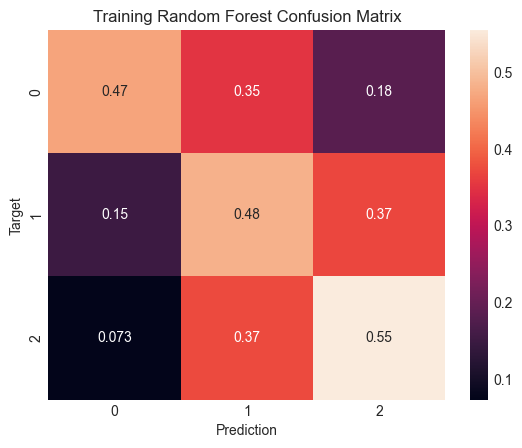

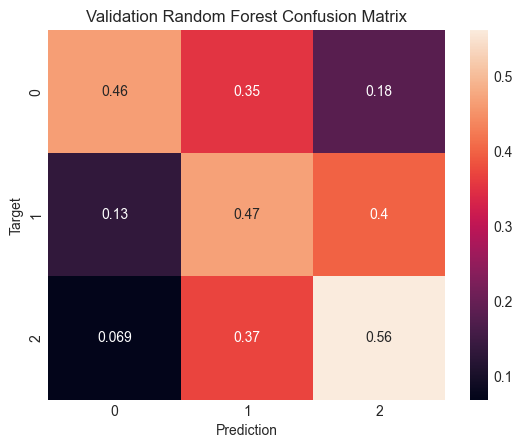

In [6]:
completed_pl = ImbPipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ('smoteenn', SMOTEENN(sampling_strategy='auto', random_state=42, n_jobs=-1)),
        ("classifier", LogisticRegression(C=1, penalty='l2', solver='liblinear', max_iter=1500))
    ]
)

completed_pl.fit(X_train, y_train)

train_preds_rf = helper.predict_and_plot(completed_pl, X_train, y_train, 'Training Random Forest')
val_preds_rf = helper.predict_and_plot(completed_pl, X_test, y_test, 'Validation Random Forest')

In [8]:
print(classification_report(y_test, val_preds_rf))

              precision    recall  f1-score   support

         0.0       0.97      0.46      0.63     56926
         1.0       0.03      0.47      0.05      1401
         2.0       0.35      0.56      0.43     10608

    accuracy                           0.48     68935
   macro avg       0.45      0.50      0.37     68935
weighted avg       0.85      0.48      0.59     68935

